In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tree_models import HCV, Smooth, smoothed_prediction
from xgboost import XGBRegressor


2025-03-15 16:23:55.923 | INFO     | tree_models:fit:97 - Best parameters #33: {'max_depth': np.int64(3), 'learning_rate': np.float64(0.02)}
2025-03-15 16:23:55.964 | INFO     | tree_models:fit:97 - Best parameters #32: {'max_depth': np.int64(2), 'learning_rate': np.float64(0.05)}
2025-03-15 16:23:55.995 | INFO     | tree_models:fit:97 - Best parameters #34: {'max_depth': np.int64(2), 'learning_rate': np.float64(0.02)}


Time taken: 2.9673473834991455 seconds
Clean MSE: 0.03629687155741378


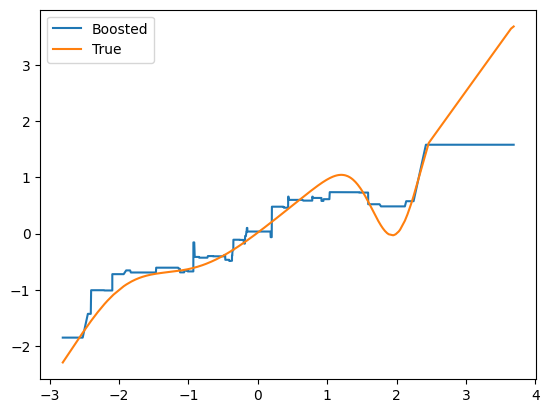

Time taken: 0.03295493125915527 seconds
Clean MSE: 0.06073564884950725


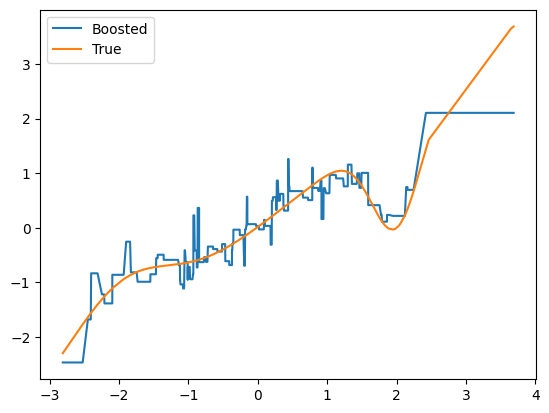

In [2]:
import time

from sklearn.model_selection import GridSearchCV


def rbf(x):
    return np.exp(-(x**2))


def f(x):
    return x + rbf(x + 2) - 2 * rbf((x - 2) * 2)


N = 1000
xs = np.random.randn(N, 1)
ys = f(xs).ravel()
noise = np.random.randn(N)
xs_train, xs_val, ys_train, ys_val = train_test_split(
    xs, ys + noise, test_size=0.2, random_state=42
)

lr = 0.2
# model_list = []
# for max_depth in [1, 2, 3, 4]:
#     for _ in range(2):
#         model_list.append(
#             XGBRegressor(max_depth=max_depth, n_estimators=10, learning_rate=lr),
#         )
# model = StackedBoosting(model_list)
model = HCV(
    XGBRegressor(
        max_depth=2,
        n_estimators=100,
        learning_rate=0.2,
    ),
)
time_start = time.time()
model.fit(xs_train, ys_train)
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")
# meta_coef = model.meta_estimator_[1].coef_
# print(meta_coef)
ps = model.predict(xs)
clean_mse = mean_squared_error(ps, ys)
print(f"Clean MSE: {clean_mse}")
argsort = np.argsort(xs[:, 0])
plt.plot(xs[argsort], ps[argsort], label="Boosted")
plt.plot(xs[argsort], ys[argsort], label="True")
plt.legend()
plt.show()

alternate_model = XGBRegressor(max_depth=2, n_estimators=100, learning_rate=0.2)
time_start = time.time()
alternate_model.fit(xs_train, ys_train)
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")
clean_mse = mean_squared_error(alternate_model.predict(xs), ys)
print(f"Clean MSE: {clean_mse}")
ps = alternate_model.predict(xs)
argsort = np.argsort(xs[:, 0])
plt.plot(xs[argsort], ps[argsort], label="Boosted")
plt.plot(xs[argsort], ys[argsort], label="True")
plt.legend()
plt.show()


In [3]:
def f(x):
    a = x[:, 0]
    b = x[:, 1]
    c = x[:, 2]
    a = np.cos(a) * np.exp(-(a**2) / 2)
    b = 0.5 * (b + np.sin(b))
    c = np.abs(c) - 1
    return a + b + c + a * b + b * c


N = 100
xs_train = np.random.randn(N, 3)
ys_train = f(xs_train)
xs_test = np.random.randn(N, 3)
ys_test = f(xs_test)

residual = ys_train
alpha = 0.5
beta = 0.0
orig_line = LinearRegression()
orig_line.fit(xs_train, ys_train)

# Implement boosting with alternating decision tree and linear function
residual = ys_train.copy()
estimators = []
feature_indices = []

for i in range(3):
    single_feature_tree = xgb.XGBRegressor(
        n_estimators=10, learning_rate=0.001, max_depth=2
    )
    single_feature_tree.fit(xs_train[:, [i]], residual)
    estimators.append(single_feature_tree)
    feature_indices.append([i])
    residual -= single_feature_tree.predict(xs_train[:, [i]])
full_tree = xgb.XGBRegressor(n_estimators=100, learning_rate=0.3, max_depth=2)
full_tree.fit(xs_train, residual)
estimators.append(full_tree)
feature_indices.append(list(range(3)))


def get_preds(X):
    return sum(
        estimator.predict(X[:, feature_indices[i]])
        for i, estimator in enumerate(estimators)
    )


total_preds = get_preds(xs_train)
residual = ys_train - total_preds
mse_train = mean_squared_error(ys_train, total_preds)

x_test = np.random.randn(N, 3)
y_test = f(x_test)
total_preds_test = get_preds(x_test)
mse_test = mean_squared_error(y_test, total_preds_test)

print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")


MSE train: 0.005512831911754272
MSE test: 0.3626662931958256
